In [1]:
%matplotlib inline  

import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from sklearn.decomposition import NMF
#from sklearn.decomposition import FastICA
#from sklearn.decomposition import RandomizedPCA
import variationalAutoencoder as VAE
#import autoencoder as AE
from preprocessing_SDSSv2 import savitzky_golay as fsg
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
data = np.load('spec4000v3_corrected.npz')
data1=data['arr_0'].item()
X = data1['X1']
Z = data1['Z']
y = data1['y']
wavelength = data1['wavelength']
mask = data1['mask']
y[y==6]=4
labels = ['Unknown','Star','Galaxy','QSO','M or later']


# Normalization dataset

In [3]:
# intensity
X1 = X.copy()
X1 = (X-X.min())/(X.max()-X.min())

# Shape
X2 = X.copy()
for ii in range(X.shape[0]):
    X2[ii] = 0.1+0.8*((X[ii]-X[ii].min())/(X[ii].max()-X[ii].min()))


# peaks
X3 = X.copy()
for ii in range(X.shape[0]):
    ytemp = fsg(X[ii],51,3)
    ytemp2 = X[ii]-ytemp
    #idxq= np.percentile(np.absolute(ytemp2), np.arange(0, 100, 25))
    #mask_q = np.where(np.absolute(ytemp2)<=idxq[-1])
    meanq = ytemp2.mean()
    stdq = ytemp2.std()
    mask_q = np.where(np.logical_and(ytemp2<=(meanq+2*stdq),ytemp2>=(meanq-2*stdq)))
    ytemp2[mask_q]=0
    #X3[ii] = 0.5+0.5*np.sign(ytemp2)
    X3[ii] = (ytemp2-ytemp2.min())/(ytemp2.max()-ytemp2.min())
    
    

In [4]:
test_size = 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    Xtrain, Xtest = X[train_idx], X[test_idx]
    ytrain, ytest = y[train_idx], y[test_idx]

In [5]:
training_epochs=500
n_z = 2

#---train shape
vaeX0 = VAE.VariationalAutoencoder(training_epochs=training_epochs,
                                  n_z=n_z,
                                  transfer_fct=tf.nn.tanh,
                                  output_fct=tf.nn.sigmoid)
vaeX0.restore('Example4000SDSS')
#vaeX0.train(X2[train_idx])
zlat0 = vaeX0.transform(X2)
Xpred0 = vaeX0.reconstruct(X2)
idx_best0 = np.argsort(-1*np.sum(np.absolute(zlat0)>0.5,axis=0))

INFO:tensorflow:Restoring parameters from temp\Example4000SDSS\model.ckpt
Model restored.


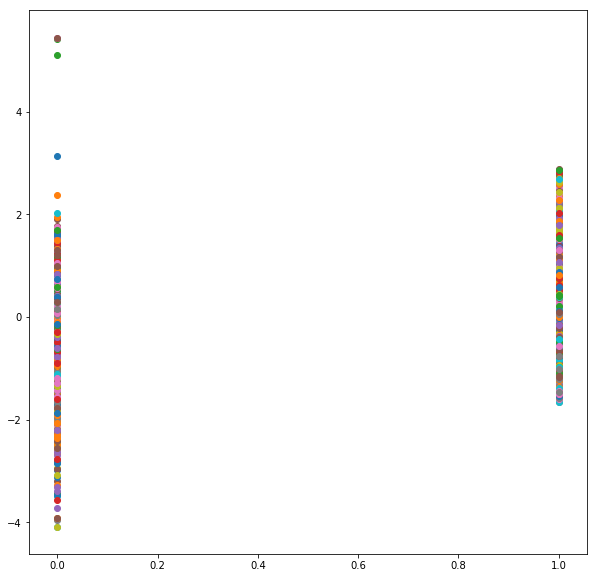

In [7]:
plt.figure(figsize=(10,10))
xx = np.arange(zlat0.shape[1])
for ii in range(zlat0.shape[0]):
    plt.scatter(xx,zlat0[ii])

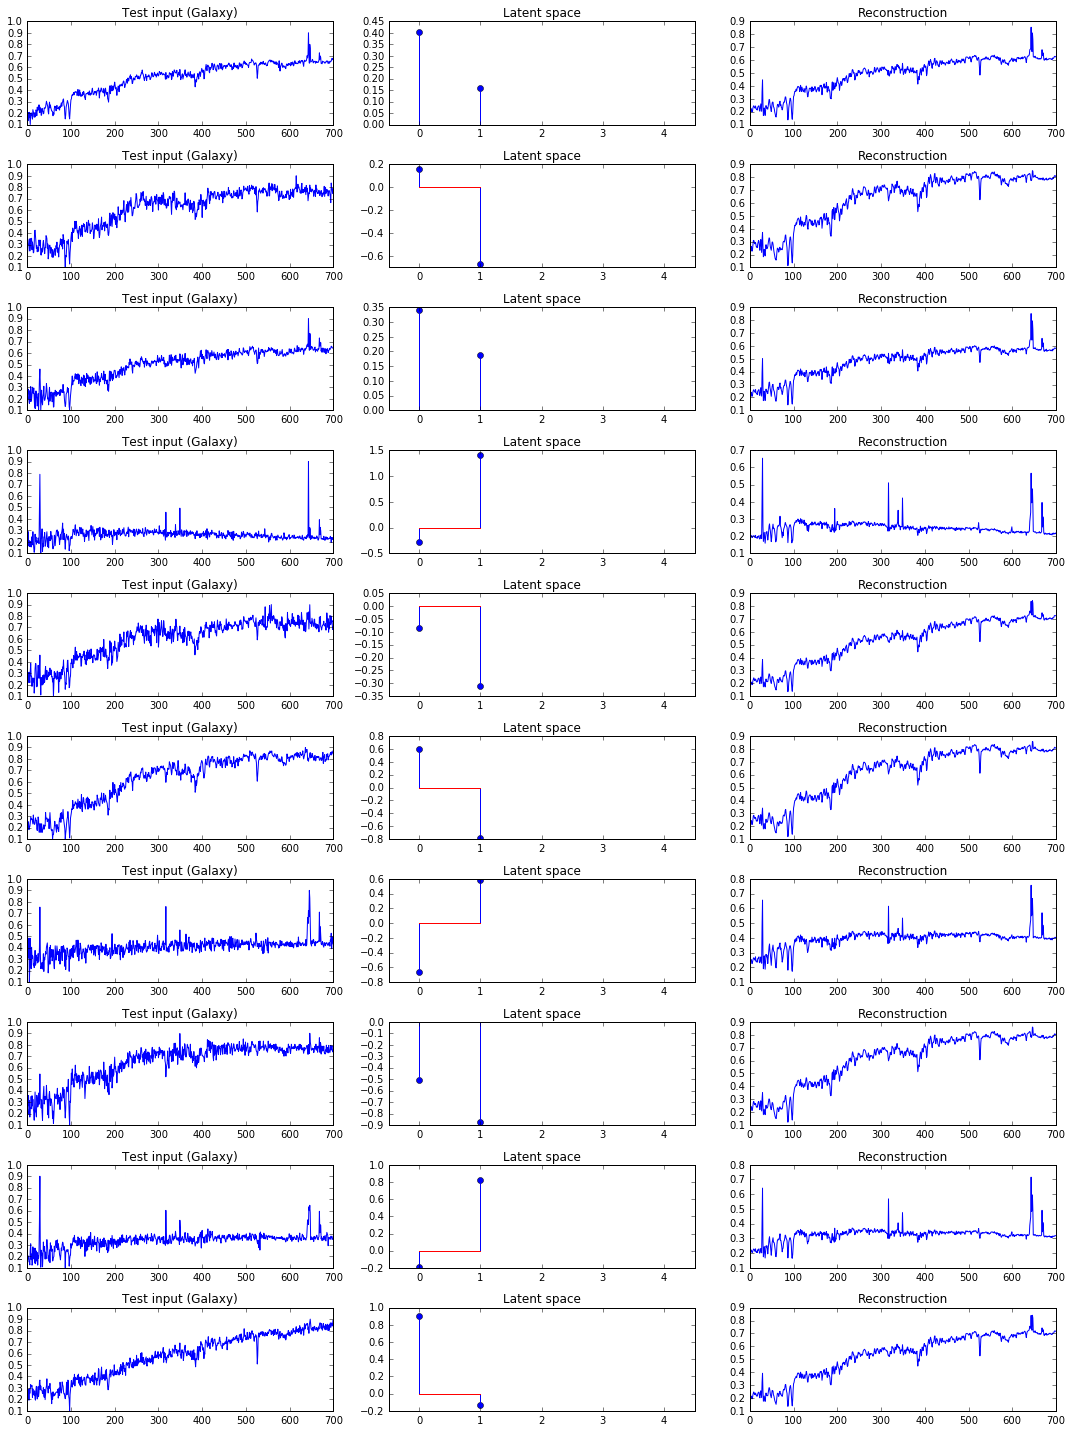

In [45]:
plt.figure(figsize=(15, 20))
idxx = np.random.randint(0,X.shape[0],10)
idxx = np.where(y==2)[0]
for i in range(10):
    plt.subplot(10, 3, 3*i + 1)
    plt.plot(X2[idxx[i]])
    plt.title("Test input (%s)" % labels[y[idxx[i]]])
    
    plt.subplot(10, 3, 3*i + 2)
    plt.stem(zlat0[idxx[i]])
    plt.xlim([-0.5,4.5])
    plt.title("Latent space")
    
    plt.subplot(10, 3, 3*i + 3)
    plt.plot(Xpred0[idxx[i]])
    plt.title("Reconstruction")
plt.tight_layout()

Exception ignored in: <bound method MatplotView.__del__ of <umatrix_vae.UMatrixView object at 0x0000007B66604FD0>>
Traceback (most recent call last):
  File "C:\Users\Atila1\Desktop\FOD_2\SDSSv2\umatrix_vae.py", line 41, in __del__
    self._close_fig()
  File "C:\Users\Atila1\Desktop\FOD_2\SDSSv2\umatrix_vae.py", line 44, in _close_fig
    if self._fig:
AttributeError: 'UMatrixView' object has no attribute '_fig'


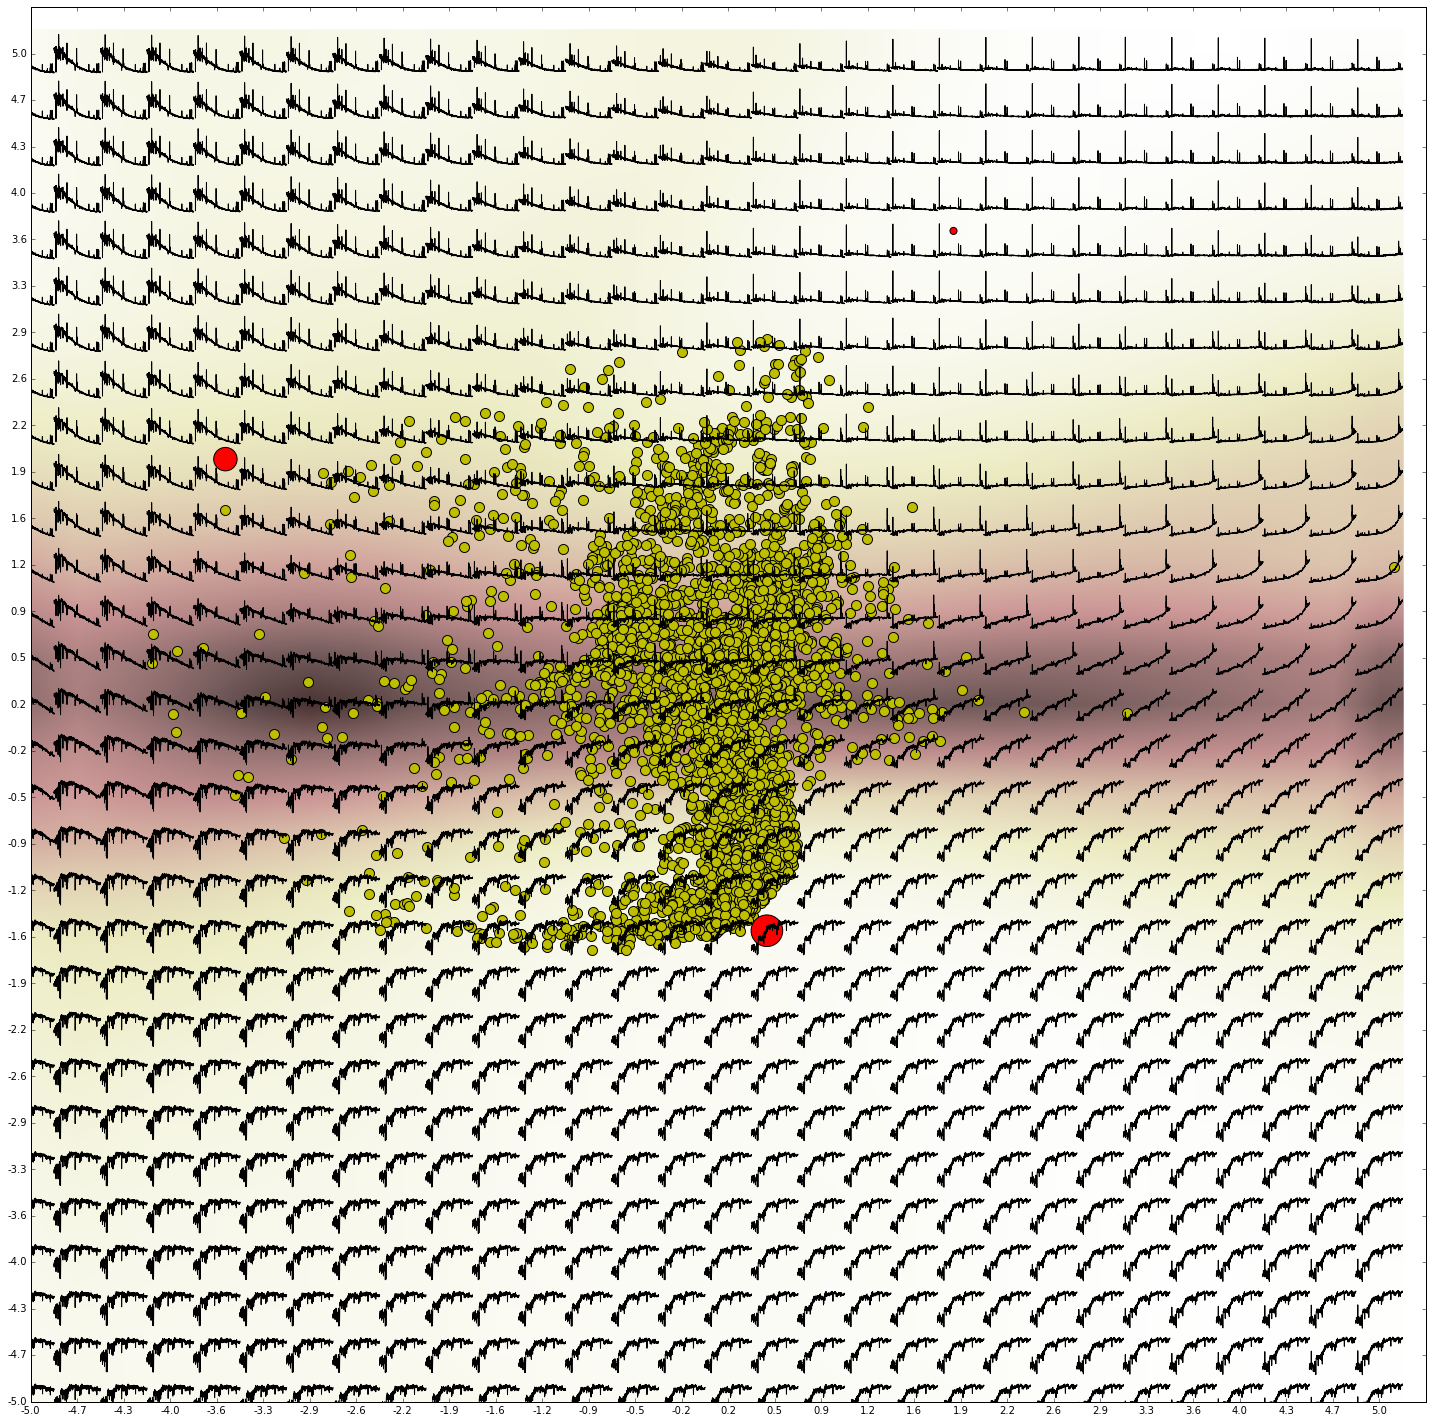

In [51]:
import umatrix_vae as umvae
grid=[30,30]
limitLattice = [-5,5,-5,5]
s=umvae.UMatrixView(limitLattice=limitLattice,grid=grid)
s.data_latent = vaeX0.transform(X2)
s.data_original = X2
s.Xgrid = vaeX0.generate(s.Zgrid.T)
#A=s.show(show_data=False)
#plt.imshow(A, cmap=plt.cm.get_cmap('RdYlBu_r'), alpha=1)
zzgrid_unit = s.Zgrid_unit.T
zzgrid = s.Zgrid.T
xxgrid = s.Xgrid
plt.figure(figsize=(20,20))
plt.imshow(s.build_u_matrix(), cmap=plt.cm.get_cmap('pink_r'), alpha=0.8,origin='lower')
xx = np.linspace(-0.5, 0.5, len(wavelength))
count = 0

for i in range(s.nnodes):
    plt.plot(zzgrid_unit[count, 0]+xx,xxgrid[count]-0.5+zzgrid_unit[count, 1],'k')
    count = count + 1
from sklearn.decomposition import NMF
nmf2 = NMF(6)
nmf2.fit(xxgrid)
nmf2_comp = nmf2.components_
nmf2_comp.shape
zzcompNMF = vaeX0.transform(nmf2_comp)
f1 = interpolate.interp1d(s.Zgrid[1,np.arange(0,s.nnodes,s.grid[1])],s.Zgrid_unit[1,np.arange(0,s.nnodes,s.grid[1])],fill_value='extrapolate')
f0 = interpolate.interp1d(s.Zgrid[0,:s.grid[0]],s.Zgrid_unit[0,:s.grid[0]],fill_value='extrapolate')
plt.scatter(f0(zlat0[:,0]),f1(zlat0[:,1]),s=100,c='y')
plt.scatter(f0(zzcompNMF[:,0]),f1(zzcompNMF[:,1]),s=np.logspace(np.log10(1000),np.log10(50),zzcompNMF.shape[0]),c='r')
plt.xlim([0,grid[0]])
plt.ylim([0,grid[1]])
plt.xticks(s.Zgrid_unit[0,:s.grid[0]],np.round(s.Zgrid[0,:s.grid[0]],1))
plt.yticks(s.Zgrid_unit[1,np.arange(0,s.nnodes,s.grid[1])],np.round(s.Zgrid[1,np.arange(0,s.nnodes,s.grid[1])],1))

plt.tight_layout()
plt.show()

In [37]:
X2.shape

(3998, 700)

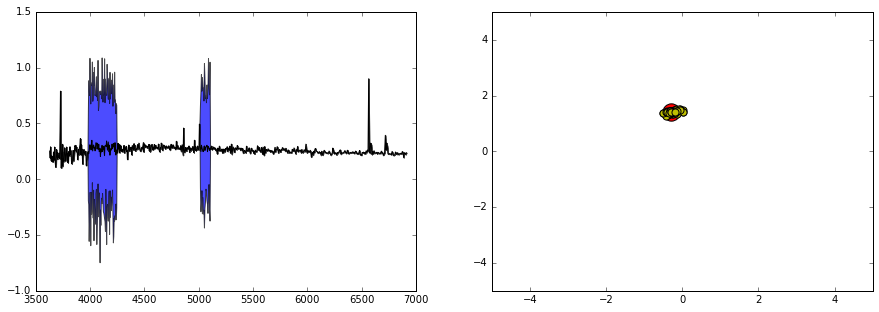

In [48]:
#vaeX.transform(X)
g = X2[3].copy()
a1=vaeX0.transform(g.reshape(1,-1))
a2 = np.zeros((100,700))
a3 = np.zeros((100,2))
idx = np.arange(350,370)
idx2 = np.arange(100,170)
#plt.scatter(wavelength,g,s=100,c='r')
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(a1[0,0],a1[0,1],s=300,c='r')
for i in range(100):
    a2[i] = g
    a2[i,idx]=g[idx]+0.3*np.random.rand()*np.random.randn(len(g[idx]))
    a2[i,idx2]=g[idx2]+0.3*np.random.rand()*np.random.randn(len(g[idx2]))
    a3[i] = vaeX0.transform(a2[i].reshape(1,-1))
    plt.scatter(a3[i,0],a3[i,1],s=50,c='y')
    #plt.scatter(wavelength,a2[i],s=50,c='g')
plt.xlim([limitLattice[0],limitLattice[1]])
plt.ylim([limitLattice[2],limitLattice[3]])

plt.subplot(1,2,1)
plt.plot(wavelength,g, 'k-')
plt.fill_between(wavelength, a2.min(axis=0), a2.max(axis=0),alpha=0.7)

plt.show()